In [1]:
%load_ext oct2py.ipython

In [2]:
%%writefile Aguiar_Gopinath_2007_notebook.mod

/*
 * This file replicates the model studied in:
 * Aguiar, Mark and Gopinath, Gita (2007): "Emerging Market Business Cycles:
 * The Cycle is the Trend", Journal of Political Economy, 115(1), pp. 69-102.
 * 
 * It provides a full replication of the main results of the original paper  
 * for the benchmark calibration. In contrast to the agmodel.mod distributed 
 * with Dynare, it calibrates the debt to GDP ratio to exactly 0.1 by analytically
 * computing the steady state.
 *
 * This mod-file shows how to deal with trend growth and how to 
 * recover the non-stationary variables from the detrended model variables.
 * 
 * Notes:
 * - The original paper uses theoretical HP-filtered moments for the 
 *   non-stationary time series. As Dynare only provides theoretical HP-filtered
 *   moments for stationary time series, the current mod-file instead uses
 *   simulated moments. This results in small moments differences in the second 
 *   digit.
 * - The FOC wrt capital is simplified to a lesser degree than the one in agtrend.mod
 *   to make explicit the use of the product rule.
 * - The paper uses NX to denote net exports as a share of GDP, not the net export level
 *
 * This implementation was written by Johannes Pfeifer. 
 * Please note that the following copyright notice only applies to this Dynare 
 * implementation of the model.
 */

/*
 * Copyright (C) 2013-2024 Johannes Pfeifer
 *
 * This is free software: you can redistribute it and/or modify
 * it under the terms of the GNU General Public License as published by
 * the Free Software Foundation, either version 3 of the License, or
 * (at your option) any later version.
 *
 * It is distributed in the hope that it will be useful,
 * but WITHOUT ANY WARRANTY; without even the implied warranty of
 * MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 * GNU General Public License for more details.
 *
 * For a copy of the GNU General Public License,
 * see <http://www.gnu.org/licenses/>.
 */

var c k y b q g l u z uc ul c_y i_y invest nx i_y_percentage c_y_percentage 
    log_y log_c log_i
    delta_y;

predetermined_variables k b; //allows using beginning of period stock notation

varexo eps_z eps_g;

parameters mu_g sigma rho_g delta phi psi b_star alpha rho_z r_star beta gamma b_share;

// Set the following variable to 0 to get the calibration for Canada
@#define mexico = 1


// Benchmark parameter values (Table 3)
beta = 1/1.02;
gamma = 0.36;
b_share   = 0.1; //10% of GDP
psi = 0.001;
alpha = 0.68;
sigma = 2;
delta = 0.05;
phi = 4;

// Estimated parameters (Table 4)
@#if mexico == 1
mu_g = log(1.0066); //is used for benchmark although not mentioned in Table 3
rho_z = 0.95;
rho_g = 0.01;
@# else
mu_g = log(1.0073); //is used for benchmark although not mentioned in Table 3
rho_z = 0.95;
rho_g = 0.01;
@# endif

//compute steady state values and calibrate the model to a steady state debt to GDP 
//ratio of 0.1
 
model;
y = exp(z)*k^(1-alpha)*(exp(g)*l)^alpha; // Production function (1)
z = rho_z*z(-1)+eps_z; // Definition transitory shock (2)
g = (1-rho_g)*mu_g+rho_g*g(-1)+eps_g; // Definition trend shock 
u = (c^gamma*(1-l)^(1-gamma))^(1-sigma)/(1-sigma); // Cobb-Douglas utility function (3)
uc = gamma*u/c*(1-sigma); //Marginal utility
ul = -(1-gamma)*u/(1-l)*(1-sigma); //Disutility of labor
c+exp(g)*k(+1)=y+(1-delta)*k-phi/2*(exp(g)*k(+1)/k-exp(mu_g))^2*k-b+q*exp(g)*b(+1); // Resource constraint (7)
1/q = 1+r_star+psi*(exp(b(+1)-b_star)-1); // Price of debt (5)
uc*(1+phi*(exp(g)*k(+1)/k-exp(mu_g)))*exp(g)=beta*exp(g*(gamma*(1-sigma)))*uc(+1)*(1-delta+(1-alpha)*y(+1)/k(+1)
                                                  -phi/2*(2*(exp(g(+1))*k(+2)/k(+1)-exp(mu_g))*(-1)*exp(g(+1))*k(+2)/k(+1)+
                                                          (exp(g(+1))*k(+2)/k(+1)-exp(mu_g))^2)); // FOC wrt to capital
ul+uc*alpha*y/l=0; // FOC wrt labor 
uc*exp(g)*q=beta*exp(g*(gamma*(1-sigma)))*uc(+1); // Euler equation for Bonds
invest = exp(g)*k(+1)-(1-delta)*k+phi/2*(exp(g)*k(+1)/k-exp(mu_g))^2*k; // Law of motion for capital (8)

//Definitional equations used for IRFs and moment computations
c_y = c/y; // Consumption to GDP ratio
i_y = invest/y; // Investment to GDP ratio
nx=(b-exp(g)*q*b(+1))/y; //Net export to GDP ratio

//Use logarithm to get variables in percentage deviations
i_y_percentage=log(i_y);
c_y_percentage=log(c_y);
log_y=log(y);
log_c=log(c);
log_i=log(invest);

//Define growth rate of output
delta_y=log(y)-log(y(-1))+g(-1);
end;

steady_state_model;
q=beta*exp(mu_g)^(gamma*(1-sigma)-1);
YKbar=((1/q)-(1-delta))/(1-alpha);
c_y=1+(1-exp(mu_g)-delta)*(1/YKbar)-(1-exp(mu_g)*q)*b_share;
l=(alpha*gamma)/(c_y-gamma*c_y+alpha*gamma);
k=(((exp(mu_g)^alpha)*(l^alpha))/YKbar)^(1/alpha);
y=k^(1-alpha)*(l*exp(mu_g))^alpha;
c=c_y*y;
invest=(exp(mu_g)-1+delta)*k;
b_star=b_share*y;
nx=(y-c-invest)/y;
r_star = 1/q-1;

b = b_star;
z = 0;
g = mu_g;
u = (c^gamma*(1-l)^(1-gamma))^(1-sigma)/(1-sigma);
uc = gamma*u/c*(1-sigma);
ul = -(1-gamma)*u/(1-l)*(1-sigma);
i_y = (exp(g)*k-(1-delta)*k)/y;
i_y_percentage=log(i_y);
c_y_percentage=log(c_y);
log_y=log(y);
log_c=log(c);
log_i=log(invest);
delta_y=mu_g;
end;


//%%%%%%%%%%%%%%%%% replicate Figure 3, p. 88-89 %%%%%%%%%%%%%%%%%%%%%%%%%
//%%%%%%%%%%%%%%%%% Uses unit shock              %%%%%%%%%%%%%%%%%%%%%%%%%
shocks;
var eps_g; stderr 1; 
var eps_z; stderr 1;
end;
resid;
steady;

check;

//%%%%%%%%%%%%%%%%%%%%%% Plot impulse response functions  %%%%%%%%%%%%%%%%
stoch_simul(order=1,nomoments,nofunctions) nx c_y_percentage i_y_percentage;

//%%%%%%%%%%%%%%%%%%%%%% Plot impulse response functions of  %%%%%%%%%%%%%%
//%%%%%%%%%%%%%%%%%%%%%% non-stationary time series          %%%%%%%%%%%%%%

//generate IRF of stationary model variables
stoch_simul(order=1,nograph) log_y log_c log_i g;
send_irfs_to_workspace;

//Now back out IRF of non-stationary model variables by adding trend growth back

log_Gamma_0=0; //Initialize Level of Technology at t=0;
log_Gamma(1,1)=g_eps_g(1,1)+log_Gamma_0; //Level of Tech. after shock in period 1

// reaccumulate the non-stationary level series; note that AG2007 detrend with X_t-1, thus the technology level in the loop is shifted by 1 period 
log_y_nonstationary = zeros(options_.irf,1);
log_c_nonstationary = zeros(options_.irf,1);
log_i_nonstationary = zeros(options_.irf,1);
for ii=2:options_.irf
    log_Gamma(ii,1)=g_eps_g(ii,1)+log_Gamma(ii-1,1);
    log_y_nonstationary(ii,1)=log_y_eps_g(ii,1)+log_Gamma(ii-1,1);
    log_c_nonstationary(ii,1)=log_c_eps_g(ii,1)+log_Gamma(ii-1,1);
    log_i_nonstationary(ii,1)=log_i_eps_g(ii,1)+log_Gamma(ii-1,1);
end

//Make the plot
figure('Name','IRF of non-detrended variables to a trend productivity shock');
subplot(3,1,1)
plot(1:options_.irf,log_y_nonstationary)
title('Output')
subplot(3,1,2)
plot(1:options_.irf,log_c_nonstationary)
title('Consumption')
subplot(3,1,3)
plot(1:options_.irf,log_i_nonstationary)
title('Investment')

//%%%%%%%%%%%%%%%%% Replicate Table 5, p. 94-95  %%%%%%%%%%%%%%%%%%%%%%%%%
//%%%%%%%%%%%%%%%%% Panel A, Column 2 (specification 1) %%%%%%%%%%%%%%%%%%

//reset shocks to specification 1 of Table 4
@#if mexico == 1
shocks;
var eps_g; stderr 2.81/100;
var eps_z; stderr 0.48/100;
end;
@# else
shocks;
var eps_g; stderr 0.88/100;
var eps_z; stderr 0.78/100;
end;
@# endif


// Simulate series on which to compute moments (Paper uses analytical moments)
stoch_simul(irf=0,order=1,periods=100000,nomoments,nofunctions) log_y delta_y c invest nx;
send_endogenous_variables_to_workspace;    

// Rebuild non-stationary time series by remultiplying with trend Gamma_{t-1}

log_Gamma_0=0; //Initialize Level of Technology at t=0;
log_Gamma(1,1)=g(1,1)+log_Gamma_0; //Level of Tech. after shock in period 1

// reaccumulate the non-stationary level series
log_y_nonstationary = zeros(options_.periods,1);
log_c_nonstationary = zeros(options_.periods,1);
log_i_nonstationary = zeros(options_.periods,1);
for ii=2:options_.periods
    log_Gamma(ii,1)=g(ii,1)+log_Gamma(ii-1,1);
    log_y_nonstationary(ii,1)=log_y(ii,1)+log_Gamma(ii-1,1);
    log_c_nonstationary(ii,1)=log_c(ii,1)+log_Gamma(ii-1,1);
    log_i_nonstationary(ii,1)=log_i(ii,1)+log_Gamma(ii-1,1);
end

// HP-filter the non-stationary time series; note that nx is share of 
// net exports in GDP and does not contain a trend by construction 

[ytrend,ycyclical]=sample_hp_filter([log_y_nonstationary log_c_nonstationary log_i_nonstationary nx],1600);

//compute standard deviations
standard_devs=std(ycyclical)*100;
standard_dev_first_diff=std(delta_y)*100;

//compute relative standard deviations
relative_standard_devs=standard_devs./standard_devs(1);

//compute autocorrelations
autocorrelations(1,1)=corr(ycyclical(2:end,1),ycyclical(1:end-1,1));
autocorrelations(2,1)=corr(delta_y(2:end,1),delta_y(1:end-1,1));

//compute correlations
correlations=corr(ycyclical(:,1),ycyclical(:,2:end));

//Display everything
fprintf('\n Table 5 - Moments\n');
fprintf('%20s \t %3.2f\n','sigma(y)',standard_devs(1,1));
fprintf('%20s \t %3.2f\n','sigma(delta y)',standard_dev_first_diff);
fprintf('%20s \t %3.2f\n','sigma(c)/sigma(y)',relative_standard_devs(2));
fprintf('%20s \t %3.2f\n','sigma(i)/sigma(y)',relative_standard_devs(3));
fprintf('%20s \t %3.2f\n','sigma(nx)/sigma(y)',relative_standard_devs(4));
fprintf('%20s \t %3.2f\n','rho(y)',autocorrelations(1,1));
fprintf('%20s \t %3.2f\n','rho(delta y)',autocorrelations(2,1));
fprintf('%20s \t %3.2f\n','rho(y,nx)',correlations(3));
fprintf('%20s \t %3.2f\n','rho(y,c)',correlations(1));
fprintf('%20s \t %3.2f\n','rho(y,i)',correlations(2));

Overwriting Aguiar_Gopinath_2007_notebook.mod



    _pyeval at line 57 column 30





If you are under Debian or Ubuntu, you can install it through your package manager, with 'apt install x13as'.

If you are under Windows or macOS, this probably means that you did not install the dseries toolbox through an official package.

Starting Dynare (version 6.1).

Calling Dynare with arguments: none

Starting preprocessing of the model file ...

Found 21 equation(s).

Evaluating expressions...

Computing static model derivatives (order 1).

Normalizing the static model...

Finding the optimal block decomposition of the static model...

5 block(s) found:

  4 recursive block(s) and 1 simultaneous block(s).

  the largest simultaneous block has 9 equation(s)

                                 and 9 feedback variable(s).

Computing dynamic model derivatives (order 1).

Normalizing the dynamic model...

Finding the optimal block decomposition of the dynamic model...

3 block(s) found:

  2 recursive block(s) and 1 simultaneous block(s).

  the largest simultaneous block has 9 equation(s)

                                 and 7 feedback variable(s).

Preprocessing completed.

Preprocessing time: 0h00m00s.

Residuals of the static equations:

Equation number  1: y              :       0.000000

Equation number  2: z              :       0.000000

Equation number  3: g              :       0.000000

Equation number  4: u              :       0.000000

Equation number  5: uc             :       0.000000

Equation number  6: ul             :       0.000000

Equation number  7: 7              :       0.000000

Equation number  8: 8              :       0.000000

Equation number  9: 9              :       0.000000

Equation number 10: 10             :       0.000000

Equation number 11: 11             :       0.000000

Equation number 12: invest         :       0.000000

Equation number 13: c_y            :       0.000000

Equation number 14: i_y            :       0.000000

Equation number 15: nx             :       0.000000

Equation number 16: i_y_percentage :       0.000000

Equation number 17: c_y_percentage :       0.000000

Equation number 18: log_y          :       0.000000

Equation number 19: log_c          :       0.000000

Equation number 20: log_i          :       0.000000

Equation number 21: delta_y        :       0.000000

STEADY-STATE RESULTS:

c              		 0.496156

k              		 2.60788

y              		 0.645177

b              		 0.0645177

q              		 0.97166

g              		 0.00657832

l              		 0.332169

u              		 -1.66644

z              		 0

uc             		 1.20914

ul             		 -1.597

c_y            		 0.769023

i_y            		 0.228784

invest         		 0.147606

nx             		 0.00219269

i_y_percentage 		 -1.47498

c_y_percentage 		 -0.262634

log_y          		 -0.438231

log_c          		 -0.700865

log_i          		 -1.91321

delta_y        		 0.00657832

EIGENVALUES:

         Modulus             Real        Imaginary

               0                0                0

            0.01             0.01                0

          0.9158           0.9158                0

            0.95             0.95                0

          0.9827           0.9827                0

            1.04             1.04                0

           1.116            1.116                0

             Inf              Inf                0

             Inf              Inf                0

There are 4 eigenvalue(s) larger than 1 in modulus for 4 forward-looking variable(s)

The rank condition is verified.

MODEL SUMMARY

  Number of variables:         21

  Number of stochastic shocks: 2

  Number of state variables:   5

  Number of jumpers:           4

  Number of static variables:  15

MATRIX OF COVARIANCE OF EXOGENOUS SHOCKS

Variables       eps_z     eps_g

eps_z        1.000000  0.000000

eps_g        0.000000  1.000000

qt.qpa.fonts: Populating font family aliases took 74 ms. Replace uses of missing font family "FreeSans" with one that exists to avoid this cost.

qt.qpa.fonts: Populating font family aliases took 73 ms. Replace uses of missing font family "FreeSans" with one that exists to avoid this cost.

MODEL SUMMARY

  Number of variables:         21

  Number of stochastic shocks: 2

  Number of state variables:   5

  Number of jumpers:           4

  Number of static variables:  15

MATRIX OF COVARIANCE OF EXOGENOUS SHOCKS

Variables       eps_z     eps_g

eps_z        1.000000  0.000000

eps_g        0.000000  1.000000

MODEL SUMMARY

  Number of variables:         21

  Number of stochastic shocks: 2

  Number of state variables:   5

  Number of jumpers:           4

  Number of static variables:  15

MATRIX OF COVARIANCE OF EXOGENOUS SHOCKS

Variables       eps_z     eps_g

eps_z        0.000023  0.000000

eps_g        0.000000  0.000790

 Table 5 - Moments

            sigma(y) 	 2.41

      sigma(delta y) 	 1.73

   sigma(c)/sigma(y) 	 1.26

   sigma(i)/sigma(y) 	 2.59

  sigma(nx)/sigma(y) 	 0.71

              rho(y) 	 0.78

        rho(delta y) 	 0.13

           rho(y,nx) 	 -0.66

            rho(y,c) 	 0.94

            rho(y,i) 	 0.92

Total computing time : 0h00m16s

Note: warning(s) encountered in MATLAB/Octave code

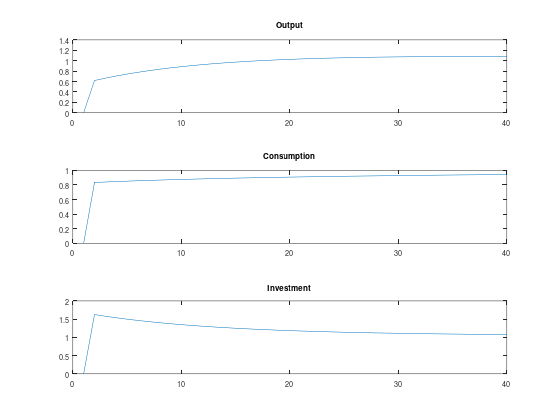

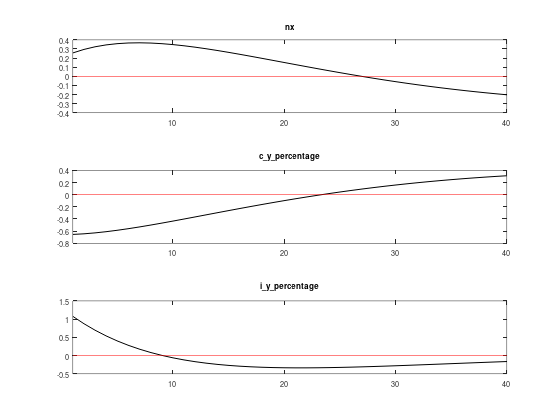

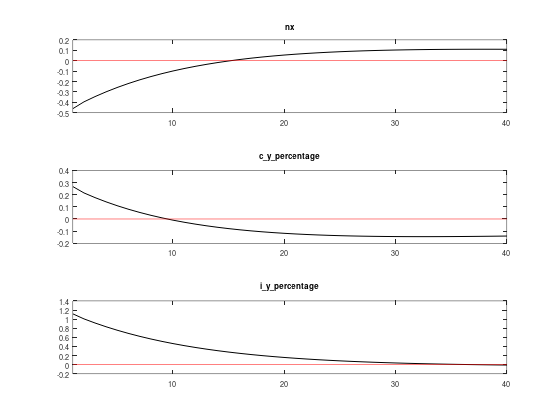

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-2.22044605e-16],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.66533454e-16],
       [ 0.00000000e+00],
       [-2.49800181e-16],
       [-1.93855348e-16],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

In [3]:
%octave addpath /usr/local/lib/dynare/matlab
%octave dynare Aguiar_Gopinath_2007_notebook.mod

In [8]:
%%writefile Aguiar_Gopinath_2007_notebook_2.mod

/*
 * This file replicates the model studied in:
 * Aguiar, Mark and Gopinath, Gita (2007): "Emerging Market Business Cycles:
 * The Cycle is the Trend", Journal of Political Economy, 115(1), pp. 69-102.
 * 
 * It provides a full replication of the main results of the original paper  
 * for the benchmark calibration. In contrast to the agmodel.mod distributed 
 * with Dynare, it calibrates the debt to GDP ratio to exactly 0.1 by analytically
 * computing the steady state.
 *
 * This mod-file shows how to deal with trend growth and how to 
 * recover the non-stationary variables from the detrended model variables.
 * 
 * Notes:
 * - The original paper uses theoretical HP-filtered moments for the 
 *   non-stationary time series. As Dynare only provides theoretical HP-filtered
 *   moments for stationary time series, the current mod-file instead uses
 *   simulated moments. This results in small moments differences in the second 
 *   digit.
 * - The FOC wrt capital is simplified to a lesser degree than the one in agtrend.mod
 *   to make explicit the use of the product rule.
 * - The paper uses NX to denote net exports as a share of GDP, not the net export level
 *
 * This implementation was written by Johannes Pfeifer. 
 * Please note that the following copyright notice only applies to this Dynare 
 * implementation of the model.
 */

/*
 * Copyright (C) 2013-2024 Johannes Pfeifer
 *
 * This is free software: you can redistribute it and/or modify
 * it under the terms of the GNU General Public License as published by
 * the Free Software Foundation, either version 3 of the License, or
 * (at your option) any later version.
 *
 * It is distributed in the hope that it will be useful,
 * but WITHOUT ANY WARRANTY; without even the implied warranty of
 * MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 * GNU General Public License for more details.
 *
 * For a copy of the GNU General Public License,
 * see <http://www.gnu.org/licenses/>.
 */

var c k y b q g l u z uc ul c_y i_y invest nx i_y_percentage c_y_percentage 
    log_y log_c log_i
    delta_y;

predetermined_variables k b; //allows using beginning of period stock notation

varexo eps_z eps_g;

parameters mu_g sigma rho_g delta phi psi b_star alpha rho_z r_star beta gamma b_share;

// Set the following variable to 0 to get the calibration for Canada
@#define mexico = 1


// Benchmark parameter values (Table 3)
beta = 1/1.02;
gamma = 0.36;
b_share   = 0.1; //10% of GDP
psi = 0.001;
alpha = 0.68;
sigma = 2;
delta = 0.05;
phi = 4;

// Estimated parameters (Table 4)
@#if mexico == 1
mu_g = log(1.0066); //is used for benchmark although not mentioned in Table 3
rho_z = 0.95;
rho_g = 0.01;
@# else
mu_g = log(1.0073); //is used for benchmark although not mentioned in Table 3
rho_z = 0.95;
rho_g = 0.01;
@# endif

//compute steady state values and calibrate the model to a steady state debt to GDP 
//ratio of 0.1
 
model;
y = exp(z)*k^(1-alpha)*(exp(g)*l)^alpha; // Production function (1)
z = rho_z*z(-1)+eps_z; // Definition transitory shock (2)
g = (1-rho_g)*mu_g+rho_g*g(-1)+eps_g; // Definition trend shock 
u = (c^gamma*(1-l)^(1-gamma))^(1-sigma)/(1-sigma); // Cobb-Douglas utility function (3)
uc = gamma*u/c*(1-sigma); //Marginal utility
ul = -(1-gamma)*u/(1-l)*(1-sigma); //Disutility of labor
c+exp(g)*k(+1)=y+(1-delta)*k-phi/2*(exp(g)*k(+1)/k-exp(mu_g))^2*k-b+q*exp(g)*b(+1); // Resource constraint (7)
1/q = 1+r_star+psi*(exp(b(+1)-b_star)-1); // Price of debt (5)
uc*(1+phi*(exp(g)*k(+1)/k-exp(mu_g)))*exp(g)=beta*exp(g*(gamma*(1-sigma)))*uc(+1)*(1-delta+(1-alpha)*y(+1)/k(+1)
                                                  -phi/2*(2*(exp(g(+1))*k(+2)/k(+1)-exp(mu_g))*(-1)*exp(g(+1))*k(+2)/k(+1)+
                                                          (exp(g(+1))*k(+2)/k(+1)-exp(mu_g))^2)); // FOC wrt to capital
ul+uc*alpha*y/l=0; // FOC wrt labor 
uc*exp(g)*q=beta*exp(g*(gamma*(1-sigma)))*uc(+1); // Euler equation for Bonds
invest = exp(g)*k(+1)-(1-delta)*k+phi/2*(exp(g)*k(+1)/k-exp(mu_g))^2*k; // Law of motion for capital (8)

//Definitional equations used for IRFs and moment computations
c_y = c/y; // Consumption to GDP ratio
i_y = invest/y; // Investment to GDP ratio
nx=(b-exp(g)*q*b(+1))/y; //Net export to GDP ratio

//Use logarithm to get variables in percentage deviations
i_y_percentage=log(i_y);
c_y_percentage=log(c_y);
log_y=log(y);
log_c=log(c);
log_i=log(invest);

//Define growth rate of output
delta_y=log(y)-log(y(-1))+g(-1);
end;

steady_state_model;
q=beta*exp(mu_g)^(gamma*(1-sigma)-1);
YKbar=((1/q)-(1-delta))/(1-alpha);
c_y=1+(1-exp(mu_g)-delta)*(1/YKbar)-(1-exp(mu_g)*q)*b_share;
l=(alpha*gamma)/(c_y-gamma*c_y+alpha*gamma);
k=(((exp(mu_g)^alpha)*(l^alpha))/YKbar)^(1/alpha);
y=k^(1-alpha)*(l*exp(mu_g))^alpha;
c=c_y*y;
invest=(exp(mu_g)-1+delta)*k;
b_star=b_share*y;
nx=(y-c-invest)/y;
r_star = 1/q-1;

b = b_star;
z = 0;
g = mu_g;
u = (c^gamma*(1-l)^(1-gamma))^(1-sigma)/(1-sigma);
uc = gamma*u/c*(1-sigma);
ul = -(1-gamma)*u/(1-l)*(1-sigma);
i_y = (exp(g)*k-(1-delta)*k)/y;
i_y_percentage=log(i_y);
c_y_percentage=log(c_y);
log_y=log(y);
log_c=log(c);
log_i=log(invest);
delta_y=mu_g;
end;


//%%%%%%%%%%%%%%%%% Replicate Table 5, p. 94-95  %%%%%%%%%%%%%%%%%%%%%%%%%
//%%%%%%%%%%%%%%%%% Panel A, Column 2 (specification 1) %%%%%%%%%%%%%%%%%%

//reset shocks to specification 1 of Table 4
@#if mexico == 1
shocks;
var eps_g; stderr 2.7454/100;
var eps_z; stderr 0.9735/100;
end;
@# else
shocks;
var eps_g; stderr 1.4982/100;
var eps_z; stderr 0.7025/100;
end;
@# endif


// Simulate series on which to compute moments (Paper uses analytical moments)
stoch_simul(irf=0,order=1,periods=100000,nomoments,nofunctions) log_y delta_y c invest nx;
send_endogenous_variables_to_workspace;    

// Rebuild non-stationary time series by remultiplying with trend Gamma_{t-1}

log_Gamma_0=0; //Initialize Level of Technology at t=0;
log_Gamma(1,1)=g(1,1)+log_Gamma_0; //Level of Tech. after shock in period 1

// reaccumulate the non-stationary level series
log_y_nonstationary = zeros(options_.periods,1);
log_c_nonstationary = zeros(options_.periods,1);
log_i_nonstationary = zeros(options_.periods,1);
for ii=2:options_.periods
    log_Gamma(ii,1)=g(ii,1)+log_Gamma(ii-1,1);
    log_y_nonstationary(ii,1)=log_y(ii,1)+log_Gamma(ii-1,1);
    log_c_nonstationary(ii,1)=log_c(ii,1)+log_Gamma(ii-1,1);
    log_i_nonstationary(ii,1)=log_i(ii,1)+log_Gamma(ii-1,1);
end

// HP-filter the non-stationary time series; note that nx is share of 
// net exports in GDP and does not contain a trend by construction 

[ytrend,ycyclical]=sample_hp_filter([log_y_nonstationary log_c_nonstationary log_i_nonstationary nx],1600);

//compute standard deviations
standard_devs=std(ycyclical)*100;
standard_dev_first_diff=std(delta_y)*100;

//compute relative standard deviations
relative_standard_devs=standard_devs./standard_devs(1);

//compute autocorrelations
autocorrelations(1,1)=corr(ycyclical(2:end,1),ycyclical(1:end-1,1));
autocorrelations(2,1)=corr(delta_y(2:end,1),delta_y(1:end-1,1));

//compute correlations
correlations=corr(ycyclical(:,1),ycyclical(:,2:end));

//Display everything
fprintf('\n Table 5 - Moments Mexico \n');
fprintf('%20s \t %3.2f\n','sigma(y)',standard_devs(1,1));
fprintf('%20s \t %3.2f\n','sigma(delta y)',standard_dev_first_diff);
fprintf('%20s \t %3.2f\n','sigma(c)/sigma(y)',relative_standard_devs(2));
fprintf('%20s \t %3.2f\n','sigma(i)/sigma(y)',relative_standard_devs(3));
fprintf('%20s \t %3.2f\n','sigma(nx)/sigma(y)',relative_standard_devs(4));
fprintf('%20s \t %3.2f\n','rho(y)',autocorrelations(1,1));
fprintf('%20s \t %3.2f\n','rho(delta y)',autocorrelations(2,1));
fprintf('%20s \t %3.2f\n','rho(y,nx)',correlations(3));
fprintf('%20s \t %3.2f\n','rho(y,c)',correlations(1));
fprintf('%20s \t %3.2f\n','rho(y,i)',correlations(2));

Overwriting Aguiar_Gopinath_2007_notebook_2.mod


In [9]:
%octave dynare Aguiar_Gopinath_2007_notebook_2.mod

If you are under Debian or Ubuntu, you can install it through your package manager, with 'apt install x13as'.

If you are under Windows or macOS, this probably means that you did not install the dseries toolbox through an official package.

Starting Dynare (version 6.1).

Calling Dynare with arguments: none

Starting preprocessing of the model file ...

Found 21 equation(s).

Evaluating expressions...

Computing static model derivatives (order 1).

Normalizing the static model...

Finding the optimal block decomposition of the static model...

5 block(s) found:

  4 recursive block(s) and 1 simultaneous block(s).

  the largest simultaneous block has 9 equation(s)

                                 and 9 feedback variable(s).

Computing dynamic model derivatives (order 1).

Normalizing the dynamic model...

Finding the optimal block decomposition of the dynamic model...

3 block(s) found:

  2 recursive block(s) and 1 simultaneous block(s).

  the largest simultaneous block has 9 equation(s)

                                 and 7 feedback variable(s).

Preprocessing completed.

Preprocessing time: 0h00m00s.

MODEL SUMMARY

  Number of variables:         21

  Number of stochastic shocks: 2

  Number of state variables:   5

  Number of jumpers:           4

  Number of static variables:  15

MATRIX OF COVARIANCE OF EXOGENOUS SHOCKS

Variables       eps_z     eps_g

eps_z        0.000095  0.000000

eps_g        0.000000  0.000754

 Table 5 - Moments Mexico

            sigma(y) 	 2.80

      sigma(delta y) 	 2.03

   sigma(c)/sigma(y) 	 1.10

   sigma(i)/sigma(y) 	 2.37

  sigma(nx)/sigma(y) 	 0.61

              rho(y) 	 0.77

        rho(delta y) 	 0.10

           rho(y,nx) 	 -0.42

            rho(y,c) 	 0.90

            rho(y,i) 	 0.92

Total computing time : 0h00m09s

Note: warning(s) encountered in MATLAB/Octave code

0.0

In [10]:
%%writefile Aguiar_Gopinath_2007_notebook_3.mod

/*
 * This file replicates the model studied in:
 * Aguiar, Mark and Gopinath, Gita (2007): "Emerging Market Business Cycles:
 * The Cycle is the Trend", Journal of Political Economy, 115(1), pp. 69-102.
 * 
 * It provides a full replication of the main results of the original paper  
 * for the benchmark calibration. In contrast to the agmodel.mod distributed 
 * with Dynare, it calibrates the debt to GDP ratio to exactly 0.1 by analytically
 * computing the steady state.
 *
 * This mod-file shows how to deal with trend growth and how to 
 * recover the non-stationary variables from the detrended model variables.
 * 
 * Notes:
 * - The original paper uses theoretical HP-filtered moments for the 
 *   non-stationary time series. As Dynare only provides theoretical HP-filtered
 *   moments for stationary time series, the current mod-file instead uses
 *   simulated moments. This results in small moments differences in the second 
 *   digit.
 * - The FOC wrt capital is simplified to a lesser degree than the one in agtrend.mod
 *   to make explicit the use of the product rule.
 * - The paper uses NX to denote net exports as a share of GDP, not the net export level
 *
 * This implementation was written by Johannes Pfeifer. 
 * Please note that the following copyright notice only applies to this Dynare 
 * implementation of the model.
 */

/*
 * Copyright (C) 2013-2024 Johannes Pfeifer
 *
 * This is free software: you can redistribute it and/or modify
 * it under the terms of the GNU General Public License as published by
 * the Free Software Foundation, either version 3 of the License, or
 * (at your option) any later version.
 *
 * It is distributed in the hope that it will be useful,
 * but WITHOUT ANY WARRANTY; without even the implied warranty of
 * MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 * GNU General Public License for more details.
 *
 * For a copy of the GNU General Public License,
 * see <http://www.gnu.org/licenses/>.
 */

var c k y b q g l u z uc ul c_y i_y invest nx i_y_percentage c_y_percentage 
    log_y log_c log_i
    delta_y;

predetermined_variables k b; //allows using beginning of period stock notation

varexo eps_z eps_g;

parameters mu_g sigma rho_g delta phi psi b_star alpha rho_z r_star beta gamma b_share;

// Set the following variable to 0 to get the calibration for Canada
@#define mexico = 0


// Benchmark parameter values (Table 3)
beta = 1/1.02;
gamma = 0.36;
b_share   = 0.1; //10% of GDP
psi = 0.001;
alpha = 0.68;
sigma = 2;
delta = 0.05;
phi = 4;

// Estimated parameters (Table 4)
@#if mexico == 1
mu_g = log(1.0066); //is used for benchmark although not mentioned in Table 3
rho_z = 0.95;
rho_g = 0.01;
@# else
mu_g = log(1.0073); //is used for benchmark although not mentioned in Table 3
rho_z = 0.95;
rho_g = 0.01;
@# endif

//compute steady state values and calibrate the model to a steady state debt to GDP 
//ratio of 0.1
 
model;
y = exp(z)*k^(1-alpha)*(exp(g)*l)^alpha; // Production function (1)
z = rho_z*z(-1)+eps_z; // Definition transitory shock (2)
g = (1-rho_g)*mu_g+rho_g*g(-1)+eps_g; // Definition trend shock 
u = (c^gamma*(1-l)^(1-gamma))^(1-sigma)/(1-sigma); // Cobb-Douglas utility function (3)
uc = gamma*u/c*(1-sigma); //Marginal utility
ul = -(1-gamma)*u/(1-l)*(1-sigma); //Disutility of labor
c+exp(g)*k(+1)=y+(1-delta)*k-phi/2*(exp(g)*k(+1)/k-exp(mu_g))^2*k-b+q*exp(g)*b(+1); // Resource constraint (7)
1/q = 1+r_star+psi*(exp(b(+1)-b_star)-1); // Price of debt (5)
uc*(1+phi*(exp(g)*k(+1)/k-exp(mu_g)))*exp(g)=beta*exp(g*(gamma*(1-sigma)))*uc(+1)*(1-delta+(1-alpha)*y(+1)/k(+1)
                                                  -phi/2*(2*(exp(g(+1))*k(+2)/k(+1)-exp(mu_g))*(-1)*exp(g(+1))*k(+2)/k(+1)+
                                                          (exp(g(+1))*k(+2)/k(+1)-exp(mu_g))^2)); // FOC wrt to capital
ul+uc*alpha*y/l=0; // FOC wrt labor 
uc*exp(g)*q=beta*exp(g*(gamma*(1-sigma)))*uc(+1); // Euler equation for Bonds
invest = exp(g)*k(+1)-(1-delta)*k+phi/2*(exp(g)*k(+1)/k-exp(mu_g))^2*k; // Law of motion for capital (8)

//Definitional equations used for IRFs and moment computations
c_y = c/y; // Consumption to GDP ratio
i_y = invest/y; // Investment to GDP ratio
nx=(b-exp(g)*q*b(+1))/y; //Net export to GDP ratio

//Use logarithm to get variables in percentage deviations
i_y_percentage=log(i_y);
c_y_percentage=log(c_y);
log_y=log(y);
log_c=log(c);
log_i=log(invest);

//Define growth rate of output
delta_y=log(y)-log(y(-1))+g(-1);
end;

steady_state_model;
q=beta*exp(mu_g)^(gamma*(1-sigma)-1);
YKbar=((1/q)-(1-delta))/(1-alpha);
c_y=1+(1-exp(mu_g)-delta)*(1/YKbar)-(1-exp(mu_g)*q)*b_share;
l=(alpha*gamma)/(c_y-gamma*c_y+alpha*gamma);
k=(((exp(mu_g)^alpha)*(l^alpha))/YKbar)^(1/alpha);
y=k^(1-alpha)*(l*exp(mu_g))^alpha;
c=c_y*y;
invest=(exp(mu_g)-1+delta)*k;
b_star=b_share*y;
nx=(y-c-invest)/y;
r_star = 1/q-1;

b = b_star;
z = 0;
g = mu_g;
u = (c^gamma*(1-l)^(1-gamma))^(1-sigma)/(1-sigma);
uc = gamma*u/c*(1-sigma);
ul = -(1-gamma)*u/(1-l)*(1-sigma);
i_y = (exp(g)*k-(1-delta)*k)/y;
i_y_percentage=log(i_y);
c_y_percentage=log(c_y);
log_y=log(y);
log_c=log(c);
log_i=log(invest);
delta_y=mu_g;
end;


//%%%%%%%%%%%%%%%%% Replicate Table 5, p. 94-95  %%%%%%%%%%%%%%%%%%%%%%%%%
//%%%%%%%%%%%%%%%%% Panel A, Column 2 (specification 1) %%%%%%%%%%%%%%%%%%

//reset shocks to specification 1 of Table 4
@#if mexico == 1
shocks;
var eps_g; stderr 2.7454/100;
var eps_z; stderr 0.9735/100;
end;
@# else
shocks;
var eps_g; stderr 1.4982/100;
var eps_z; stderr 0.7025/100;
end;
@# endif


// Simulate series on which to compute moments (Paper uses analytical moments)
stoch_simul(irf=0,order=1,periods=100000,nomoments,nofunctions) log_y delta_y c invest nx;
send_endogenous_variables_to_workspace;    

// Rebuild non-stationary time series by remultiplying with trend Gamma_{t-1}

log_Gamma_0=0; //Initialize Level of Technology at t=0;
log_Gamma(1,1)=g(1,1)+log_Gamma_0; //Level of Tech. after shock in period 1

// reaccumulate the non-stationary level series
log_y_nonstationary = zeros(options_.periods,1);
log_c_nonstationary = zeros(options_.periods,1);
log_i_nonstationary = zeros(options_.periods,1);
for ii=2:options_.periods
    log_Gamma(ii,1)=g(ii,1)+log_Gamma(ii-1,1);
    log_y_nonstationary(ii,1)=log_y(ii,1)+log_Gamma(ii-1,1);
    log_c_nonstationary(ii,1)=log_c(ii,1)+log_Gamma(ii-1,1);
    log_i_nonstationary(ii,1)=log_i(ii,1)+log_Gamma(ii-1,1);
end

// HP-filter the non-stationary time series; note that nx is share of 
// net exports in GDP and does not contain a trend by construction 

[ytrend,ycyclical]=sample_hp_filter([log_y_nonstationary log_c_nonstationary log_i_nonstationary nx],1600);

//compute standard deviations
standard_devs=std(ycyclical)*100;
standard_dev_first_diff=std(delta_y)*100;

//compute relative standard deviations
relative_standard_devs=standard_devs./standard_devs(1);

//compute autocorrelations
autocorrelations(1,1)=corr(ycyclical(2:end,1),ycyclical(1:end-1,1));
autocorrelations(2,1)=corr(delta_y(2:end,1),delta_y(1:end-1,1));

//compute correlations
correlations=corr(ycyclical(:,1),ycyclical(:,2:end));

//Display everything
fprintf('\n Table 5 - Moments Canada \n');
fprintf('%20s \t %3.2f\n','sigma(y)',standard_devs(1,1));
fprintf('%20s \t %3.2f\n','sigma(delta y)',standard_dev_first_diff);
fprintf('%20s \t %3.2f\n','sigma(c)/sigma(y)',relative_standard_devs(2));
fprintf('%20s \t %3.2f\n','sigma(i)/sigma(y)',relative_standard_devs(3));
fprintf('%20s \t %3.2f\n','sigma(nx)/sigma(y)',relative_standard_devs(4));
fprintf('%20s \t %3.2f\n','rho(y)',autocorrelations(1,1));
fprintf('%20s \t %3.2f\n','rho(delta y)',autocorrelations(2,1));
fprintf('%20s \t %3.2f\n','rho(y,nx)',correlations(3));
fprintf('%20s \t %3.2f\n','rho(y,c)',correlations(1));
fprintf('%20s \t %3.2f\n','rho(y,i)',correlations(2));

Overwriting Aguiar_Gopinath_2007_notebook_3.mod


In [11]:
%octave dynare Aguiar_Gopinath_2007_notebook_3.mod

If you are under Debian or Ubuntu, you can install it through your package manager, with 'apt install x13as'.

If you are under Windows or macOS, this probably means that you did not install the dseries toolbox through an official package.

Starting Dynare (version 6.1).

Calling Dynare with arguments: none

Starting preprocessing of the model file ...

Found 21 equation(s).

Evaluating expressions...

Computing static model derivatives (order 1).

Normalizing the static model...

Finding the optimal block decomposition of the static model...

5 block(s) found:

  4 recursive block(s) and 1 simultaneous block(s).

  the largest simultaneous block has 9 equation(s)

                                 and 9 feedback variable(s).

Computing dynamic model derivatives (order 1).

Normalizing the dynamic model...

Finding the optimal block decomposition of the dynamic model...

3 block(s) found:

  2 recursive block(s) and 1 simultaneous block(s).

  the largest simultaneous block has 9 equation(s)

                                 and 7 feedback variable(s).

Preprocessing completed.

Preprocessing time: 0h00m00s.

MODEL SUMMARY

  Number of variables:         21

  Number of stochastic shocks: 2

  Number of state variables:   5

  Number of jumpers:           4

  Number of static variables:  15

MATRIX OF COVARIANCE OF EXOGENOUS SHOCKS

Variables       eps_z     eps_g

eps_z        0.000049  0.000000

eps_g        0.000000  0.000224

 Table 5 - Moments Canada

            sigma(y) 	 1.73

      sigma(delta y) 	 1.26

   sigma(c)/sigma(y) 	 1.00

   sigma(i)/sigma(y) 	 2.25

  sigma(nx)/sigma(y) 	 0.55

              rho(y) 	 0.76

        rho(delta y) 	 0.08

           rho(y,nx) 	 -0.26

            rho(y,c) 	 0.88

            rho(y,i) 	 0.92

Total computing time : 0h00m09s

Note: warning(s) encountered in MATLAB/Octave code

0.0